# Recommendation System


## Dataset description

This data set contains information on user preference data from 73,516 users on 12,294 anime. Each user is able to add anime to their completed list and give it a rating and this data set is a compilation of those ratings.

Anime.csv


*   anime_id - myanimelist.net's unique id identifying an anime.
*   name - full name of anime.
*   genre - comma separated list of genres for this anime.
*   type - movie, TV, OVA, etc.
*   episodes - how many episodes in this show. (1 if movie).
*   rating - average rating out of 10 for this anime.
*   members - number of community members that are in this anime's "group".

Rating.csv
*   user_id - non identifiable randomly generated user id.
*   anime_id - the anime that this user has rated.
*   rating - rating out of 10 this user has assigned (-1 if the user watched it but didn't assign a rating).

[Source of dataset and more details](https://www.kaggle.com/CooperUnion/anime-recommendations-database)

**Our goal is to build a recommender system to make recommendations to user based on their rating records.**

## Importing modules and data

In [1]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import torch
import torch.nn as nn
import random
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import sklearn.utils

In [0]:
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")

In [0]:
anime = pd.read_csv('./drive/My Drive/Colab Notebooks/anime-recommendations-database/anime.csv')
rating = pd.read_csv('./drive/My Drive/Colab Notebooks/anime-recommendations-database/rating.csv')

## Exploring the data

In [5]:
anime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
anime_id    12294 non-null int64
name        12294 non-null object
genre       12232 non-null object
type        12269 non-null object
episodes    12294 non-null object
rating      12064 non-null float64
members     12294 non-null int64
dtypes: float64(1), int64(2), object(4)
memory usage: 672.4+ KB


In [6]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813737 entries, 0 to 7813736
Data columns (total 3 columns):
user_id     int64
anime_id    int64
rating      int64
dtypes: int64(3)
memory usage: 178.8 MB


In [7]:
anime.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [8]:
rating.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [9]:
anime.describe()

,anime_id,rating,members
count,12294.000000,12064.000000,1.229400e+04
mean,14058.221653,6.473902,1.807134e+04
std,11455.294701,1.026746,5.482068e+04
min,1.000000,1.670000,5.000000e+00
25%,3484.250000,5.880000,2.250000e+02
50%,10260.500000,6.570000,1.550000e+03
75%,24794.500000,7.180000,9.437000e+03
max,34527.000000,10.000000,1.013917e+06


In [10]:
rating.describe()

,user_id,anime_id,rating
count,7.813737e+06,7.813737e+06,7.813737e+06
mean,3.672796e+04,8.909072e+03,6.144030e+00
std,2.099795e+04,8.883950e+03,3.727800e+00
min,1.000000e+00,1.000000e+00,-1.000000e+00
25%,1.897400e+04,1.240000e+03,6.000000e+00
50%,3.679100e+04,6.213000e+03,7.000000e+00
75%,5.475700e+04,1.409300e+04,9.000000e+00
max,7.351600e+04,3.451900e+04,1.000000e+01


In [11]:
anime.isna().sum()

anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64

In [12]:
rating.isna().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

In [13]:
print('Number of animes in the dataset: ', anime.anime_id.unique().shape)

Number of animes in the dataset:  (12294,)


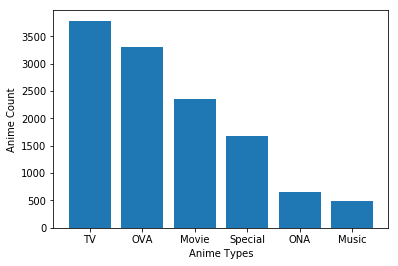

In [14]:
anime_types = anime.type.value_counts()
plt.bar(x=anime_types.index, height = anime_types.values)
plt.xlabel('Anime Types')
plt.ylabel('Anime Count')
plt.show()

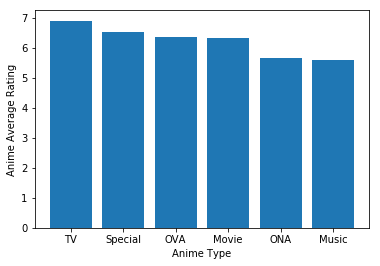

In [15]:
anime_types_rating = anime.groupby('type')['rating'].mean().sort_values(ascending=False)
plt.bar(x=anime_types_rating.index, height=anime_types_rating.values)
plt.xlabel('Anime Type')
plt.ylabel('Anime Average Rating')
plt.show()

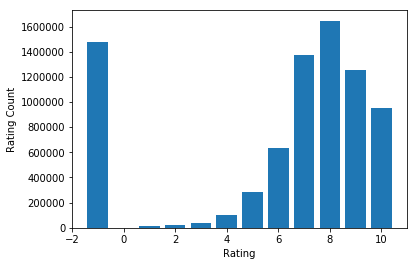

In [16]:
plt.bar(rating.groupby('rating').count().index, rating.groupby('rating').count().anime_id)
plt.xlabel('Rating')
plt.ylabel('Rating Count')
plt.show()

In [0]:
anime_genre = anime.genre.dropna().apply(lambda x: set(x.split(','))).values
genres = dict()
for genre in anime_genre:
    for g in genre:
        if genres.get(g.strip()) == None:
            genres[g.strip()] = 0
        else:
            genres[g.strip()] += 1

In [0]:
genres_df = pd.DataFrame.from_dict(genres, orient='index').reset_index().rename(columns={'index': 'genre', 0:'count'})
genres_df = genres_df.sort_values(by='count', ascending=False)

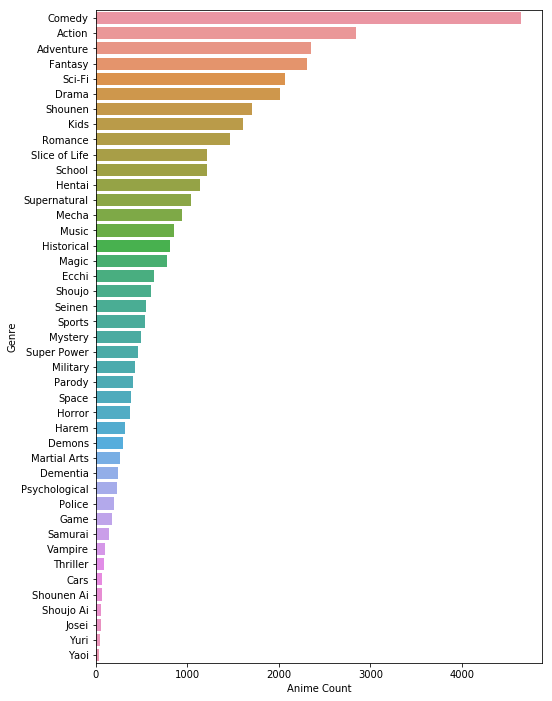

In [19]:
figure, ax = plt.subplots(figsize=(8, 12))
sns.barplot(x='count', y='genre', data=genres_df)
ax.set(ylabel='Genre', xlabel='Anime Count')
plt.show()

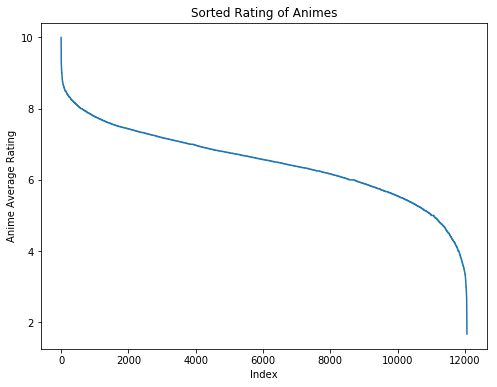

In [20]:
plt.figure(figsize=(8,6))
plt.plot(anime.index, anime.rating.sort_values(ascending=False))
plt.xlabel('Index')
plt.ylabel('Anime Average Rating')
plt.title('Sorted Rating of Animes')
plt.show()

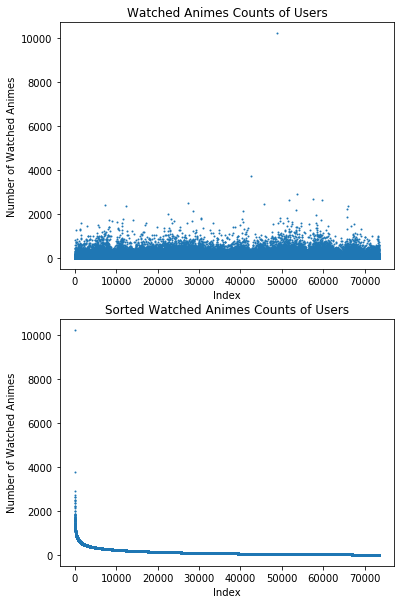

In [21]:
user_watched_count = rating.groupby('user_id').rating.count()

figure, ax = plt.subplots(2,1, figsize=(6, 10))
ax[0].scatter(range(len(user_watched_count)),user_watched_count, s=1)
ax[0].set_xlabel('Index')
ax[0].set_ylabel('Number of Watched Animes')
ax[0].set_title('Watched Animes Counts of Users')

ax[1].scatter(range(len(user_watched_count)),user_watched_count.sort_values(ascending=False), s=1)
ax[1].set_xlabel('Index')
ax[1].set_ylabel('Number of Watched Animes')
ax[1].set_title('Sorted Watched Animes Counts of Users')

plt.show()

In [22]:
watched_counts = 5
inactive_users = user_watched_count < watched_counts
inactive_users = inactive_users[inactive_users]
print('Number of users watched less than {} animes: {}'.format(watched_counts, inactive_users.shape[0]))
print('There are a lot users watched very few animes')

Number of users watched less than 5 animes: 6645
There are a lot users watched very few animes


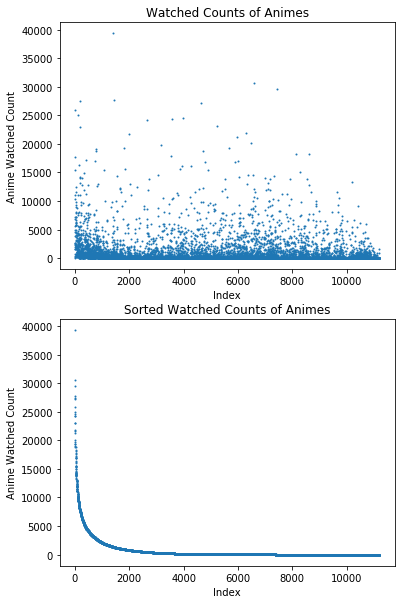

In [23]:
anime_watched_count = rating.groupby('anime_id').rating.count()

figure, ax = plt.subplots(2,1, figsize=(6, 10))
ax[0].scatter(range(len(anime_watched_count)),anime_watched_count, s=1)
ax[0].set_xlabel('Index')
ax[0].set_ylabel('Anime Watched Count')
ax[0].set_title('Watched Counts of Animes')

ax[1].scatter(range(len(anime_watched_count)),anime_watched_count.sort_values(ascending=False), s=1)
ax[1].set_xlabel('Index')
ax[1].set_ylabel('Anime Watched Count')
ax[1].set_title('Sorted Watched Counts of Animes')
plt.show()

In [24]:
watched_counts = 10
unpopular_animes = anime_watched_count < watched_counts
unpopular_animes = unpopular_animes[unpopular_animes]
print('Number of animes have been watched less than {} times: {}'.format(watched_counts,unpopular_animes.shape[0]))
print('There are a lot animes have been watched very few times')

Number of animes have been watched less than 10 times: 3451
There are a lot animes have been watched very few times


In [25]:
merged_df = pd.merge(anime, rating, on='anime_id')
merged_df.head()

,anime_id,name,genre,type,episodes,rating_x,members,user_id,rating_y
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,99,5
1,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,152,10
2,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,244,10
3,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,271,10
4,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,278,-1


In [26]:
top10rated = merged_df.groupby('name')['rating_x'].count().sort_values(ascending=False).head(10)
top10rated

name
Death Note                          39340
Sword Art Online                    30583
Shingeki no Kyojin                  29584
Code Geass: Hangyaku no Lelouch     27718
Elfen Lied                          27506
Angel Beats!                        27183
Naruto                              25925
Fullmetal Alchemist                 25032
Fullmetal Alchemist: Brotherhood    24574
Toradora!                           24283
Name: rating_x, dtype: int64

**We remove the very popular items from the rating table since users are very likely to discover those items themselves.**

In [0]:
watched_counts = 20000
popular_animes = anime_watched_count > watched_counts
popular_animes = popular_animes[popular_animes]
rating = rating[~ rating.anime_id.isin(popular_animes.index)]

In [29]:
num_user = rating.user_id.unique().shape[0]
print('Number of users: ', num_user)

Number of users:  72688


In [30]:
animes_valid = rating.anime_id.unique()
num_anime = animes_valid.shape[0]
print('Number of animes have been rated: ', num_anime)

Number of animes have been rated:  11183


## Data preparation

In [0]:
num_anime = rating.anime_id.unique().shape[0] # numbers of anime
num_user = rating.user_id.unique().shape[0] # numbers of user

# Create dictionary to map anime_id to anime index and vice versa
# anime index is used for model's input 
anime_id2idx = dict(zip(np.sort(rating.anime_id.unique()), range(num_anime)))
anime_idx2id = {v: k for k, v in anime_id2idx.items()}

# Create dictionary to map user_id to user index and vice versa
# user index is used for model's input
user_id2idx = dict(zip(np.sort(rating.user_id.unique()), range(num_user)))
user_idx2id = {v: k for k, v in user_id2idx.items()}

# Creat dictionary to map anime_id to anime name
anime_id2name = dict(zip(merged_df.anime_id, merged_df.name))

In [32]:
RANDOM_SEED = 2019

# Only use data with valid rating
rating_filtered = rating[rating.rating != -1]
# X = rating_filtered[['user_id', 'anime_id']]
rating_filtered.loc[:,'user_id'] = rating_filtered.user_id.apply(lambda x: user_id2idx.get(x))
rating_filtered.loc[:,'anime_id'] = rating_filtered.anime_id.apply(lambda x: anime_id2idx.get(x))
# y = rating_filtered.rating

rating_filtered_train, rating_filtered_val = train_test_split(rating_filtered, test_size=0.3, random_state=RANDOM_SEED)
rating_filtered_val, rating_filtered_test = train_test_split(rating_filtered_val, test_size=0.3, random_state=RANDOM_SEED)

# For generating training data, validation or testing data
def ratingData(rating_data, shuffle):
    if shuffle:
        rating_data = sklearn.utils.shuffle(rating_data)
    user_idx_train = torch.from_numpy(rating_data.user_id.values).to(device)
    anime_idx_train = torch.from_numpy(rating_data.anime_id.values).to(device)
    target_train = torch.FloatTensor(rating_data.rating.values).to(device)
    return user_idx_train, anime_idx_train, target_train



/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:635: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


## Building model

To build a recommender system, we are trying to build a model that predicts the rating of items by users. In order to achieve this, we want our model approxiates the existing rating table, and hopefully, it will generalize to unrated items. 

In the following, we are going to employ colaborative filtering approach to build our model. The core assumption of colaborative filtering is that users who have similar preferences in the past are likely to have similar preferences in the future.

A 'completed' rating table $R$ is a $n_u \times n_i$ matrix, where $n_u$ is the numbers of user and $n_i$ is the numbers of item. We assume that it can be assembled with two components, namely, the item matrix $\Theta$ and the user matrix $X$. $\Theta$ is a $k \times n_i$ matrix, and $X$ is a $k \times n_u$ matrix. The $k$-dimensional latent factors of $\Theta$ can be interpreted as the features of the items, and the $k$-dimensional latent factors of $X$ can be interpreted as users' preferences on those features,  $k$ is can be assumed to be much less than $n_u$ and $n_i$. And we can approximate the rating table $R$ by the product of $X^T$ and $\Theta$, i.e. $R \approx X^T\Theta$.

The elements of the matrices $\Theta$ and $X$ are the parameters that our model is going to learn from the existing rating data. We use mean square error as the metric for the approximation. Suppose that 
$\Theta = [\theta^{(0)} \ \theta^{(1)} \ \cdots \ \theta^{(n_i-1)}]$ and 
$X = [x^{(0)} \ x^{(1)} \ \cdots \ x^{(n_u-1)}]$. 

The predicted rating table $\hat{R} = X^T \Theta = \begin{bmatrix} 
(x^{(0)})^T \theta^{(0)} & (x^{(0)})^T \theta^{(1)} & \cdots & (x^{(0)})^T \theta^{(n_i-1)}\\                
(x^{(1)})^T \theta^{(0)} & (x^{(1)})^T \theta^{(1)} & \cdots & (x^{(1)})^T \theta^{(n_i-1)} \\
\vdots & \vdots & \vdots & \vdots \\
(x^{(n_u-1)})^T \theta^{(0)} & (x^{(n_u-1)})^T \theta^{(1)} & \cdots & (x^{(n_u-1)})^T \theta^{(n_i-1)}
\end{bmatrix}.$

So we train our model by minimizing the objective function $$\frac{1}{2} \sum_{p(i,j)=1} \left( (x^{(i)})^T \theta^{(j)} - r^{(i,j)} \right)^2 + \frac{\lambda}{2} \sum_{j=1}^{n_u} \sum_{k=1}^n (\theta_k^{(j)})^2 + \frac{\lambda}{2} \sum_{j=1}^{n_u} \sum_{k=1}^n (x_k^{(j)})^2$$
where $p(i,j) = 1$ if user $i$ has rated item $j$ and $p(i,j) = 0 $ otherwise. The presence of $\frac{\lambda}{2} \sum_{j=1}^{n_u} \sum_{k=1}^n (\theta_k^{(j)})^2 + \frac{\lambda}{2} \sum_{j=1}^{n_u} \sum_{k=1}^n (x_k^{(j)})^2$ is for the purpose of weight regularization.

In [0]:
class CFNet(nn.Module):
    def __init__(self, num_latent, num_anime, num_user):
        super(CFNet, self).__init__()
        self.embed_user = nn.Embedding(num_user, num_latent)
        self.embed_anime = nn.Embedding(num_anime, num_latent)
        
    def forward(self, user_idx, anime_idx):
        users = self.embed_user(user_idx) # users size = user_idx.size(0) x num_latent
        animes = self.embed_anime(anime_idx) # animes size = anime_idx.size(0) x num_latent
        # shape of user_idx and shape of anime_idx are broadcastable
        ratings = (users * animes).sum(1) # rating size = user_idx.size(0)
        return ratings
    
    def weight_init(self, low, high):
        self.embed_user.weight.data.uniform_(low, high)
        self.embed_anime.weight.data.uniform_(low, high)


In [0]:
# Colborative filtering model with bias terms
class CFNetwBias(nn.Module):
    def __init__(self, num_latent, num_anime, num_user):
        super(CFNetwBias, self).__init__()
        self.embed_user = nn.Embedding(num_user, num_latent)
        self.user_bias = nn.Embedding(num_user, 1)
        self.embed_anime = nn.Embedding(num_anime, num_latent)
        self.anime_bias = nn.Embedding(num_anime, 1)
        
    def forward(self, user_idx, anime_idx):
        users = self.embed_user(user_idx) # users size = user_idx.size(0) x num_latent
        animes = self.embed_anime(anime_idx) # animes size = anime_idx.size(0) x num_latent
        bias_users = self.user_bias(user_idx).squeeze() # bias_users size = (user_idx.size(0), )
        bias_animes = self.anime_bias(anime_idx).squeeze() # bias_animes size = (anime_idx.size(0), )
        # shape of user_idx and shape of anime_idx are broadcastable
        ratings = (users * animes).sum(1) + bias_users + bias_animes # rating size = user_idx.size(0)
        return ratings
    
    def weight_init(self, low_w, high_w, low_b, high_b):
        self.embed_user.weight.data.uniform_(low_w, high_w)
        self.embed_anime.weight.data.uniform_(low_w, high_w)
        self.user_bias.weight.data.uniform_(low_b, high_b)
        self.anime_bias.weight.data.uniform_(low_b, high_b)
        

In [35]:
NUM_LATENT = 100 #len(genres)

model = CFNet(NUM_LATENT, num_anime, num_user).to(device)
model.weight_init(0.0, 0.02)

# model = CFNetwBias(NUM_LATENT, num_anime, num_user).to(device)
# model.weight_init(0.0, 0.02, -0.01, 0.01)

model

CFNet(
  (embed_user): Embedding(72688, 100)
  (embed_anime): Embedding(11183, 100)
)

## Model training

In [0]:
criterion = nn.MSELoss().to(device)
wd = 1e-6
lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=0.1, weight_decay = 1e-6)

In [0]:
train_loss = []
def train(user_idx, anime_idx, target, criterion, optimizer):
    model.train()
    prediction = model(user_idx, anime_idx)
    loss = criterion(prediction, target)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_loss.append(loss.item())
    print('\nEpoch: {}/{}\nTraining Loss: {:.4f}\t'.format(epoch+1, NUM_EPOCHS, loss.item()), end="")

val_loss = []
def validate(user_idx, anime_idx, target, criterion):
    model.eval()
    prediction = model(user_idx, anime_idx)
    loss = criterion(prediction, target)
    val_loss.append(loss.item())
    print('Validation Loss: {:.4f}'.format(loss.item()))

In [38]:
%%time
NUM_EPOCHS = 40  
print('Train on {} samples, validate on {} samples'.format(len(rating_filtered_train), len(rating_filtered_val)))
for epoch in range(NUM_EPOCHS):
    epoch_start_time = time.time()
    user_idx_train, anime_idx_train, target_train = ratingData(rating_filtered_train, shuffle=True)
    train(user_idx_train, anime_idx_train, target_train, criterion, optimizer)
    user_idx_val, anime_idx_val, target_val = ratingData(rating_filtered_val, shuffle=False)
    validate(user_idx_val, anime_idx_val, target_val, criterion)
    epoch_end_time = time.time() - epoch_start_time
    print('Time taken for epoch {}: {:3f} seconds'.format(epoch+1, epoch_end_time))

Train on 4173495 samples, validate on 1252049 samples

Epoch: 1/40
Training Loss: 62.6179	Validation Loss: 47.0643
Time taken for epoch 1: 0.764747 seconds

Epoch: 2/40
Training Loss: 47.0344	Validation Loss: 21.4205
Time taken for epoch 2: 0.622880 seconds

Epoch: 3/40
Training Loss: 21.3300	Validation Loss: 2.8586
Time taken for epoch 3: 0.619298 seconds

Epoch: 4/40
Training Loss: 2.7451	Validation Loss: 20.4563
Time taken for epoch 4: 0.610764 seconds

Epoch: 5/40
Training Loss: 20.3848	Validation Loss: 16.2138
Time taken for epoch 5: 0.623316 seconds

Epoch: 6/40
Training Loss: 16.0880	Validation Loss: 4.2718
Time taken for epoch 6: 0.641169 seconds

Epoch: 7/40
Training Loss: 4.1053	Validation Loss: 2.4357
Time taken for epoch 7: 0.634132 seconds

Epoch: 8/40
Training Loss: 2.2722	Validation Loss: 7.2046
Time taken for epoch 8: 0.624009 seconds

Epoch: 9/40
Training Loss: 7.0633	Validation Loss: 11.1926
Time taken for epoch 9: 0.630334 seconds

Epoch: 10/40
Training Loss: 11.0684

## Model evaluation and prediction

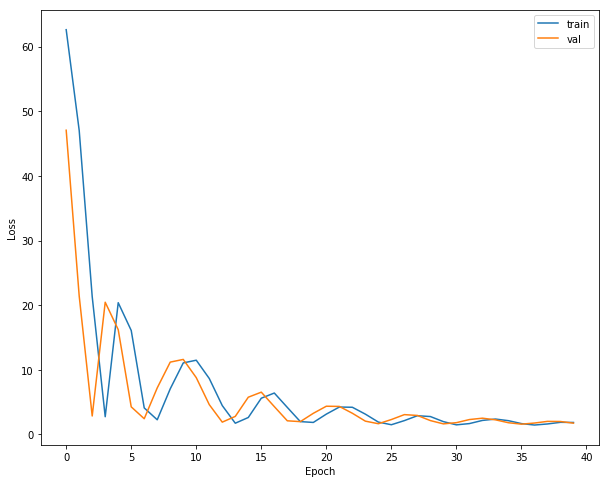

In [39]:
plt.figure(figsize=(10,8))
plt.plot(train_loss, label='train')
plt.plot(val_loss, label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [40]:
model.eval()
user_idx_test, anime_idx_test, target_test = ratingData(rating_filtered_test, shuffle=False)
prediction = model(user_idx_test, anime_idx_test)
results = pd.DataFrame({
                        'target': target_test.cpu().detach().numpy(),
                        'prediction': prediction.cpu().detach().numpy(),
                        })
show = 20
print('Prediction on test set (only first {}/{} data are shown)\n'.format(show, len(rating_filtered_test)))
print(results.head(show))
print('\nLoss:\t', criterion(prediction, target_test).item())

Prediction on test set (only first 20/536593 data are shown)

    target  prediction
0     10.0   11.650475
1      9.0    8.588098
2      7.0    7.474242
3      8.0    6.485961
4      4.0    7.274881
5      8.0    7.527821
6      9.0    7.728989
7      8.0    8.878506
8      8.0    8.589098
9      9.0    8.619560
10    10.0    9.660336
11    10.0    9.109106
12     7.0    6.498616
13     7.0    7.658408
14    10.0    8.880695
15     7.0    7.762948
16    10.0    8.975102
17     9.0    9.421947
18     8.0    7.709509
19     9.0    7.564706

Loss:	 1.7421396970748901


## Result

In [0]:
# Get Recommendation
animes_idx = torch.arange(num_anime).to(device)
def getRecommendation(user_id, animes_idx, min_score, top_num, loose):
    """
    Get top_num numbers of recommendation with predicted rating 
    at least min_score for a single user with user id = user_id.
    If loose is set to True, then return randomly selected items 
    with predicted rating at least min_score, otherwise, return 
    items with top_num highest predicted rating.
    """
    model.eval()
    user_idx = user_id2idx[user_id]
    user_idx = torch.tensor([user_idx]).to(device)
    with torch.no_grad(): 
        pred = model(animes_idx, user_idx)
    
    pred = pred.cpu().numpy()
    recommend = list(enumerate(pred))
    recommend = [elm for elm in recommend if elm[1] > min_score]
    if len(recommend) >= top_num:
        if loose: 
            recommend = random.sample(recommend, top_num)
        else:
            recommend = sorted(recommend, key=lambda x: x[1], reverse=True)
            recommend = recommend[0:top_num]
    elif 0 < len(recommend) < top_num:
        pass
    else:
        return []  
    
    output = []
    for (idx, value) in recommend:
        anime_id = anime_idx2id.get(idx)
        name = anime_id2name.get(anime_id)
        output.append((name, value))
    return output 
        

In [42]:
print('3 recommendations to user 1 to user 20 with corresponding predicted ratings\n')
for user_id in range(1,21):
    if user_id in user_id2idx.keys():
        print('user {}:'.format(user_id), getRecommendation(user_id, animes_idx, 9, 3, 1))

3 recommendations to user 1 to user 20 with corresponding predicted ratings

user 1: [('Shining Hearts: Shiawase no Pan Specials', 10.894594), ('Mahou no Mako-chan', 9.220301), ('Nasu: Andalusia no Natsu', 11.052641)]
user 2: [('Kodomo no Omocha (TV)', 9.303258), ('Rockman.EXE Beast+', 9.764195), ('Gaiking: Legend of Daiku-Maryu', 9.30369)]
user 3: [('Gegege no Kitarou: Saikyou Youkai Gundan! Nippon Jouriku!!', 9.123684), ('Hikawa Maru Monogatari', 9.8324375), ('Bishoujo Senshi Sailor Moon S', 9.107913)]
user 4: [('Manga Sekai Mukashibanashi', 9.231178), ('Hello Kitty no Papa Nante Daikirai', 9.330666), ('Tatakae! Osper', 9.254538)]
user 5: [('Avenger', 9.057657), ('UFO Princess Valkyrie', 9.544945), ('Minarai Diva', 9.126161)]
user 6: [('Aria The Natural', 9.145363), ('Kirarin☆Revolution', 9.231981), ('Battle Athletess Daiundoukai (TV)', 9.545456)]
user 7: [('Chinyuuki: Tarou to Yukai na Nakama-tachi', 11.0775175), ('Shinryaku!! Ika Musume', 9.510534), ('Kazu &amp; Yasu Hero Tanjou', 